# Use Pipeline

In [1]:
import importlib.util
import sys
import os

# Construct full path to your local ModelPipeline file (inside __init__.py)
file_path = "/Users/zoe_mac/PycharmProjects/dsi-capstone-spring-2025-TD-anti-money-laundering/Code/src/pipeline/__init__.py"

# Load the module from file
spec = importlib.util.spec_from_file_location("custom_pipeline", file_path)
custom_pipeline = importlib.util.module_from_spec(spec)
spec.loader.exec_module(custom_pipeline)

# Now use the ModelPipeline class from that module
ModelPipeline = custom_pipeline.ModelPipeline


ModuleNotFoundError: No module named 'helpers.currency'

# Load df

In [28]:
xgb_pipeline = ModelPipeline(dataset_path="/Users/zoe_mac/Desktop/EDA/subset_transactions2.csv")

xgb_pipeline.run_preprocessing()

xgb_pipeline.df

Running preprocessing pipeline...

Creating unique ids...

Normalizing currency...

Extracting time features...

Adding cyclical encoding to time feats...

Applying label encoding...

Label encoding applied to columns: ['day_of_week', 'from_bank', 'to_bank']

Applying one hot encoding...

/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
/Users/zoe_mac/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


One hot encoding applied to columns: ['payment_type', 'received_currency', 'sent_currency']

Extracting graph features...

Using default weight columns: ['sent_amount', 'received_amount']

Graph features computed using: ['sent_amount', 'received_amount']

**Note**, previously graph-based features were calculated using only `sent_amount` as edge weight (only based on 
outgoing transactions). Now both sent and received amounts are included by default.

New feature columns added: degree_centrality_sent_amount, degree_centrality_received_amount, 
pagerank_sent_amount, pagerank_received_amount

Preprocessing completed successfully!

{
    'renamed': True,
    'duplicates_removed': True,
    'unique_ids_created': True,
    'currency_normalized': True,
    'time_features_extracted': True,
    'cyclical_encoded': True,
    'weekend_encoded': True,
    'label_encoded': True,
    'neighbor_context_computed': True,
    'normalized': False,
    'onehot_encoded': True
}

,from_bank,to_bank,received_amount,sent_amount,is_laundering,from_account_id,to_account_id,from_account_idx,to_account_idx,sent_amount_usd,...,payment_type_Bitcoin,payment_type_Cash,payment_type_Cheque,payment_type_Credit Card,payment_type_Reinvestment,payment_type_Wire,degree_centrality_sent_amount,pagerank_sent_amount,degree_centrality_received_amount,pagerank_received_amount
0,8,8,3697.340000,3697.340000,0,10_8000EBD30,10_8000EBD30,0,0,3.697340e+03,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000139,0.000050,0.000139,0.000050
1,109,0,0.010000,0.010000,0,3208_8000F4580,1_8000F5340,1,81239,1.000000e-02,...,0.0,0.0,1.0,0.0,0.0,0.0,0.000019,0.000001,0.000019,0.000001
2,10,10,2806.970000,2806.970000,0,12_8000F5030,12_8000F5030,2,2,2.806970e+03,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000195,0.000243,0.000195,0.000243
3,8,8,36682.970000,36682.970000,0,10_8000F5200,10_8000F5200,3,3,3.668297e+04,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000121,0.000008,0.000121,0.000008
4,0,0,6162.440000,6162.440000,0,1_8000F5AD0,1_8000F5AD0,4,4,6.162440e+03,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000177,0.000092,0.000177,0.000092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250896,4222,3797,0.000223,0.000223,0,152627_813D6AFF1,53744_814237D21,48362,48634,1.876695e-08,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000007,0.000046,0.000007
1250897,4672,4671,0.417737,0.417737,0,254565_8147A3EC1,254355_8147A3E21,48834,75038,3.515537e-05,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000037,0.000003,0.000037,0.000003
1250898,12,4222,0.051436,0.051436,0,15_813D8E211,152627_8147AA0B1,48375,69359,4.328685e-06,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000030,0.000046,0.000030
1250899,12,4222,0.084692,0.084692,0,15_813D8E211,152627_8147AA0B1,48375,69359,7.127401e-06,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000046,0.000030,0.000046,0.000030


# Engineering One Hop Features

In [29]:
# Keep only the necessary columns from df early on
df = xgb_pipeline.df[['from_account_id', 'to_account_id', 'sent_amount_usd', 'is_laundering']].copy()
df["TxID"] = df.index

# Prepare for forward join
forward_df = df[['TxID', 'from_account_id', 'sent_amount_usd']].rename(
    columns={'TxID': 'forward_TxID',
             'from_account_id': 'receiver',
             'sent_amount_usd': 'forward_amount'}
)

# Prepare for backward join
backward_df = df[['TxID', 'to_account_id', 'sent_amount_usd']].rename(
    columns={'TxID': 'backward_TxID',
             'to_account_id': 'sender',
             'sent_amount_usd': 'backward_amount'}
)

# Forward Merge
df_forward = df.merge(forward_df, how='left', left_on='to_account_id', right_on='receiver')
df_forward = df_forward[(df_forward['forward_TxID'].isna()) | (df_forward['TxID'] != df_forward['forward_TxID'])]

# Backward Merge
df_backward = df.merge(backward_df, how='left', left_on='from_account_id', right_on='sender')
df_backward = df_backward[(df_backward['backward_TxID'].isna()) | (df_backward['TxID'] != df_backward['backward_TxID'])]

# Aggregate Features
fwd_stats = df_forward.groupby('TxID')['forward_amount'].agg(['min', 'max', 'mean', 'std']).add_prefix('onehop_forward_')
bwd_stats = df_backward.groupby('TxID')['backward_amount'].agg(['min', 'max', 'mean', 'std']).add_prefix('onehop_backward_')

# Merge with original
df_final = df.set_index('TxID').join(fwd_stats).join(bwd_stats).reset_index()


In [30]:
X1 = xgb_pipeline.df.columns
X_remove = ['TxID', 'is_laundering','from_account_id',	'to_account_id','from_account_idx','to_account_idx']

X = [x for x in X1 if x not in X_remove]

y = 'is_laundering'

# Training the Model

In [56]:
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(X,y)

Data split using random_stratified method.

In [51]:
from sklearn.metrics import classification_report, roc_auc_score

# CatBoost Model
final_model = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights={0: 1, 1: 12},
    random_seed=42,
    silent=True
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 65.5ms	remaining: 1m 5s
100:	learn: 0.3627538	test: 0.3488132	best: 0.3488132 (99)	total: 4.53s	remaining: 40.3s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.38336714
bestIteration = 153

Shrink model to first 154 iterations.
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186859
           1       0.91      0.25      0.39       777

    accuracy                           1.00    187636
   macro avg       0.96      0.62      0.69    187636
weighted avg       1.00      1.00      1.00    187636

ROC AUC Score: 0.9720


# Backward Selection

In [54]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score

def backward_feature_selection(X_train, y_train, X_val, y_val, cat_features=None, min_features=5, drop_threshold=0.01):

    current_features = X_train.columns.tolist()
    history = []

    # Initial full model
    best_model = CatBoostClassifier(
        iterations=1000,
        depth=8,
        learning_rate=0.05,
        loss_function='Logloss',
        eval_metric='F1',
        class_weights={0: 1, 1: 12},
        random_seed=42,
        silent=True
    )
    best_model.fit(Pool(X_train, y_train, cat_features=cat_features),
                   eval_set=Pool(X_val, y_val, cat_features=cat_features),
                   early_stopping_rounds=30,
                   verbose=0)

    best_f1 = f1_score(y_val, best_model.predict(X_val))
    print(f"Initial F1 score (all features): {best_f1:.4f}")

    while len(current_features) > min_features:
        # Get feature importances from model
        importances = best_model.get_feature_importance(prettified=True)
        least_important = importances.sort_values("Importances").iloc[0]["Feature Id"]
        print(f"Trying to remove: {least_important}")

        reduced_features = [f for f in current_features if f != least_important]

        # Retrain with one feature removed
        model = CatBoostClassifier(
            iterations=300,
            depth=8,
            learning_rate=0.05,
            loss_function='Logloss',
            eval_metric='F1',
            class_weights={0: 1, 1: 12},
            random_seed=42,
            silent=True
        )
        model.fit(Pool(X_train[reduced_features], y_train, cat_features=[f for f in cat_features if f in reduced_features]),
                  eval_set=Pool(X_val[reduced_features], y_val, cat_features=[f for f in cat_features if f in reduced_features]),
                  early_stopping_rounds=30,
                  verbose=0)

        val_f1 = f1_score(y_val, model.predict(X_val[reduced_features]))
        delta = best_f1 - val_f1
        print(f"F1 after removing {least_important}: {val_f1:.4f} (Δ = {delta:.4f})")

        if delta > drop_threshold:
            print("Stopping: Performance dropped too much.")
            break
        else:
            current_features = reduced_features
            best_model = model
            best_f1 = val_f1
            history.append((least_important, val_f1))

    print("\n✅ Final selected features:", current_features)
    return best_model, current_features, history

In [57]:
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()
model, selected_features, drop_history = backward_feature_selection(
    X_train, y_train, X_val, y_val, cat_features=cat_features, drop_threshold=0.01
)

Initial F1 score (all features): 0.3977
Trying to remove: payment_type_Wire
F1 after removing payment_type_Wire: 0.4002 (Δ = -0.0025)
Trying to remove: payment_type_Reinvestment
F1 after removing payment_type_Reinvestment: 0.4016 (Δ = -0.0014)
Trying to remove: sent_currency_Ruble
F1 after removing sent_currency_Ruble: 0.3990 (Δ = 0.0025)
Trying to remove: sent_currency_Yen
F1 after removing sent_currency_Yen: 0.4047 (Δ = -0.0057)
Trying to remove: sent_currency_Australian Dollar
F1 after removing sent_currency_Australian Dollar: 0.4057 (Δ = -0.0009)
Trying to remove: sent_currency_Brazil Real
F1 after removing sent_currency_Brazil Real: 0.4068 (Δ = -0.0011)
Trying to remove: received_currency_Yen
F1 after removing received_currency_Yen: 0.4164 (Δ = -0.0096)
Trying to remove: received_currency_Rupee
F1 after removing received_currency_Rupee: 0.4089 (Δ = 0.0076)
Trying to remove: sent_currency_Bitcoin
F1 after removing sent_currency_Bitcoin: 0.4097 (Δ = -0.0008)
Trying to remove: paymen

## Model Train

In [59]:
final_selected_features = ['from_bank', 'to_bank', 'received_amount', 'sent_amount', 'sent_amount_usd', 'received_amount_usd', 'hour_of_day', 'day_of_week', 'seconds_since_midnight', 'timestamp_int', 'timestamp_scaled', 'day_sin', 'day_cos', 'time_of_day_sin', 'time_of_day_cos', 'is_weekend', 'received_currency_Australian Dollar', 'received_currency_Bitcoin', 'received_currency_Brazil Real', 'received_currency_Canadian Dollar', 'received_currency_Euro', 'received_currency_Mexican Peso', 'received_currency_Ruble', 'received_currency_Saudi Riyal', 'received_currency_Shekel', 'received_currency_Swiss Franc', 'received_currency_UK Pound', 'received_currency_US Dollar', 'received_currency_Yuan', 'sent_currency_Canadian Dollar', 'sent_currency_Euro', 'sent_currency_Mexican Peso', 'sent_currency_Rupee', 'sent_currency_Saudi Riyal', 'sent_currency_Shekel', 'sent_currency_Swiss Franc', 'sent_currency_UK Pound', 'sent_currency_US Dollar', 'sent_currency_Yuan', 'payment_type_ACH', 'payment_type_Bitcoin', 'payment_type_Cash', 'payment_type_Cheque', 'degree_centrality_sent_amount', 'pagerank_sent_amount', 'degree_centrality_received_amount', 'pagerank_received_amount']

In [60]:
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(X, y)

# Select only the final features
X_train_sel = X_train[final_selected_features]
X_val_sel = X_val[final_selected_features]
X_test_sel = X_test[final_selected_features]

# Identify categorical columns if any
cat_features = X_train_sel.select_dtypes(include=["category"]).columns.tolist()

# Pools for CatBoost
train_pool = Pool(X_train_sel, y_train, cat_features=cat_features)
val_pool = Pool(X_val_sel, y_val, cat_features=cat_features)
test_pool = Pool(X_test_sel, y_test, cat_features=cat_features)

# Train model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    class_weights={0: 1, 1: 12},
    eval_metric="F1",
    random_seed=42,
    silent=True
)
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50)

# Predict and evaluate
y_pred_test = model.predict(X_test_sel)
y_pred_train = model.predict(X_train_sel)
y_pred_val = model.predict(X_val_sel)

print("Train:\n", classification_report(y_train, y_pred_train))
print("Validation:\n", classification_report(y_val, y_pred_val))
print("Test:\n", classification_report(y_test, y_pred_test))


Data split using random_stratified method.

Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    872006
           1       0.36      0.61      0.45      3624

    accuracy                           0.99    875630
   macro avg       0.68      0.80      0.72    875630
weighted avg       1.00      0.99      0.99    875630

Validation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    186859
           1       0.34      0.53      0.41       776

    accuracy                           0.99    187635
   macro avg       0.67      0.77      0.71    187635
weighted avg       1.00      0.99      0.99    187635

Test:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    186859
           1       0.30      0.51      0.38       777

    accuracy                           0.99    187636
   macro avg       0.65      0.75      0.69    187636
weighted avg       1.00      0.99      0.99   

## Model Perform

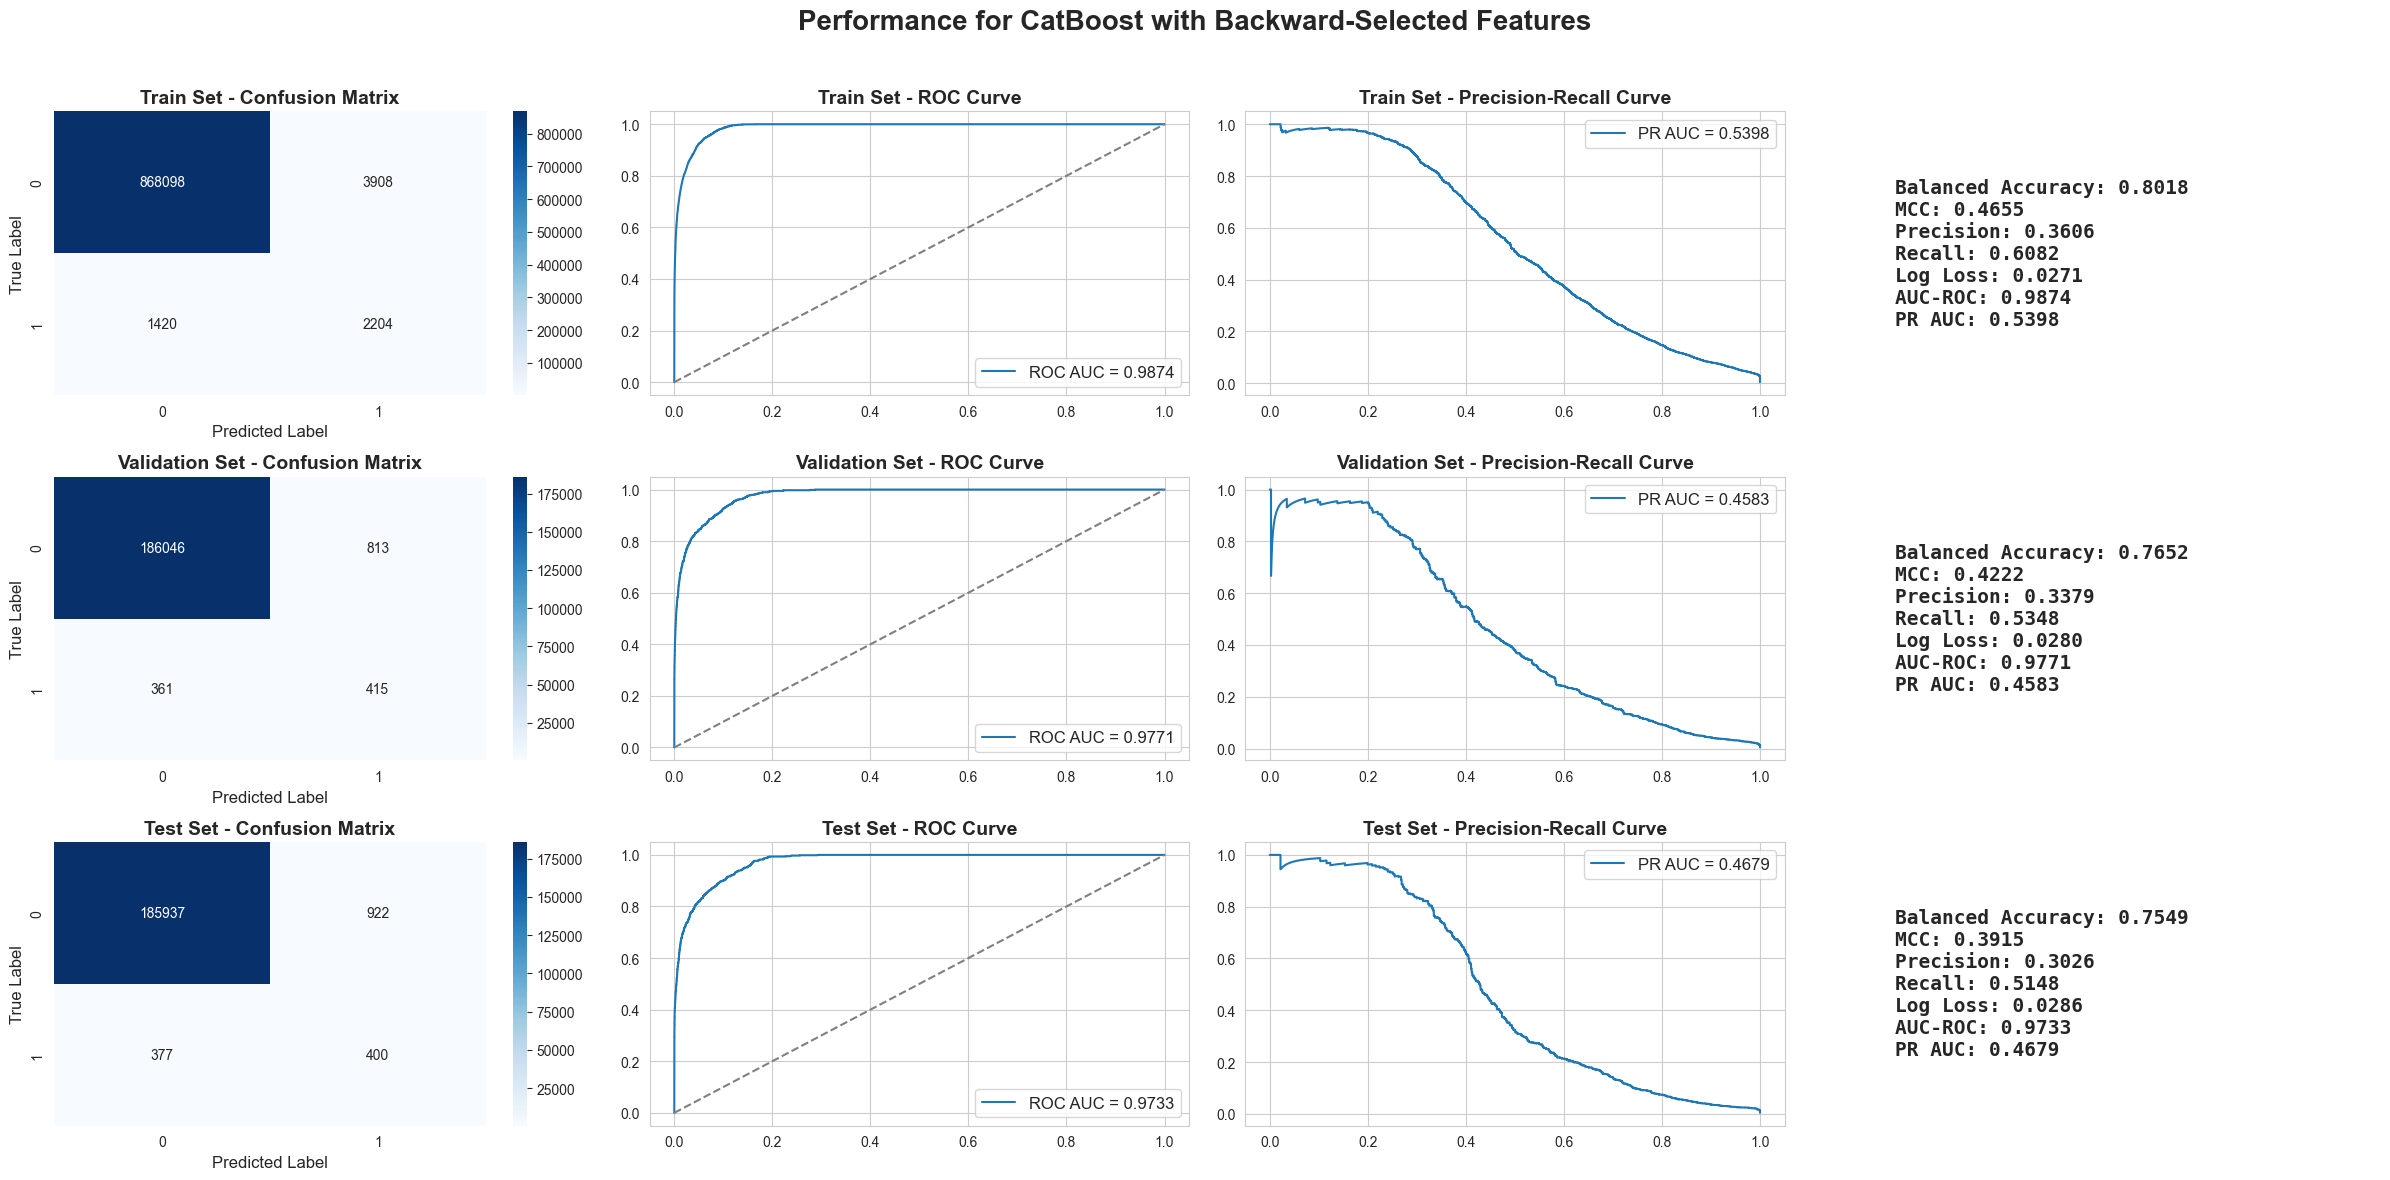

In [62]:
# Apply final selected features
X_train_sel = X_train[final_selected_features]
X_val_sel = X_val[final_selected_features]
X_test_sel = X_test[final_selected_features]

# Predict Probabilities
train_proba = model.predict_proba(X_train_sel)[:, 1]
val_proba = model.predict_proba(X_val_sel)[:, 1]
test_proba = model.predict_proba(X_test_sel)[:, 1]

# Predict Labels using 0.5 threshold
train_pred = (train_proba > 0.5).astype(int)
val_pred = (val_proba > 0.5).astype(int)
test_pred = (test_proba > 0.5).astype(int)

# Plot metrics via pipeline
slide_title = "Performance for CatBoost with Backward-Selected Features"
xgb_pipeline.result_metrics(
    slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

# Model Performance

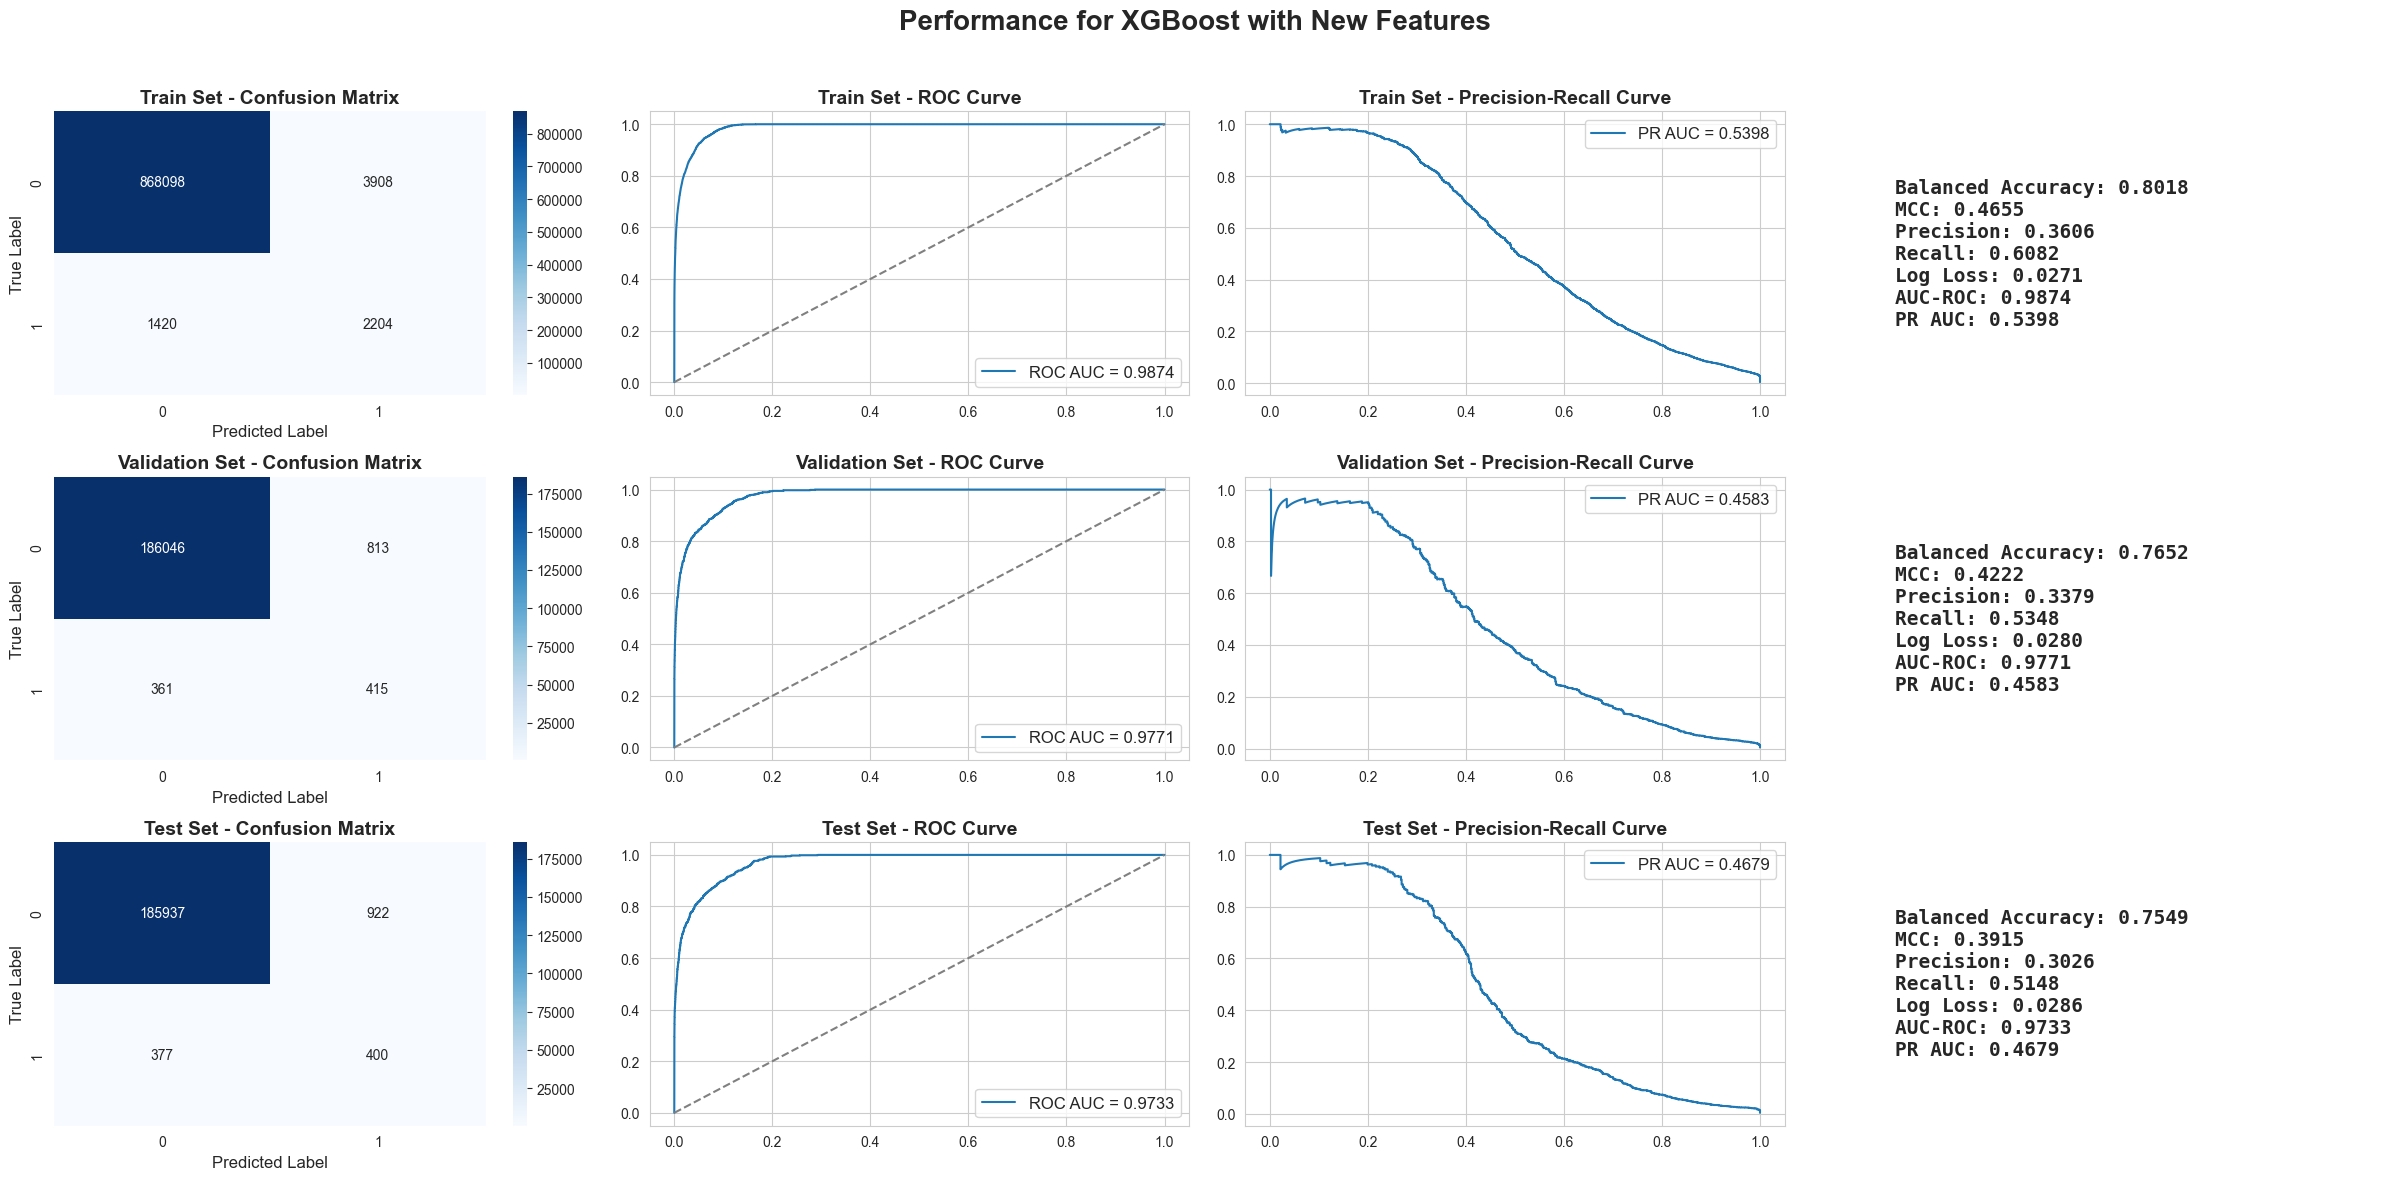

In [63]:
# Train predictions
train_proba = model.predict_proba(X_train)[:, 1]  # Get probability of class 1
train_pred = (train_proba > 0.5).astype(int)

# Validation predictions
val_proba = model.predict_proba(X_val)[:, 1]
val_pred = (val_proba > 0.5).astype(int)

# Test predictions
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba > 0.5).astype(int)


# Evaluate Model Performance
slide_title = "Performance for XGBoost with New Features"
metrics_summary = xgb_pipeline.result_metrics(
    slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)

# Shap Value

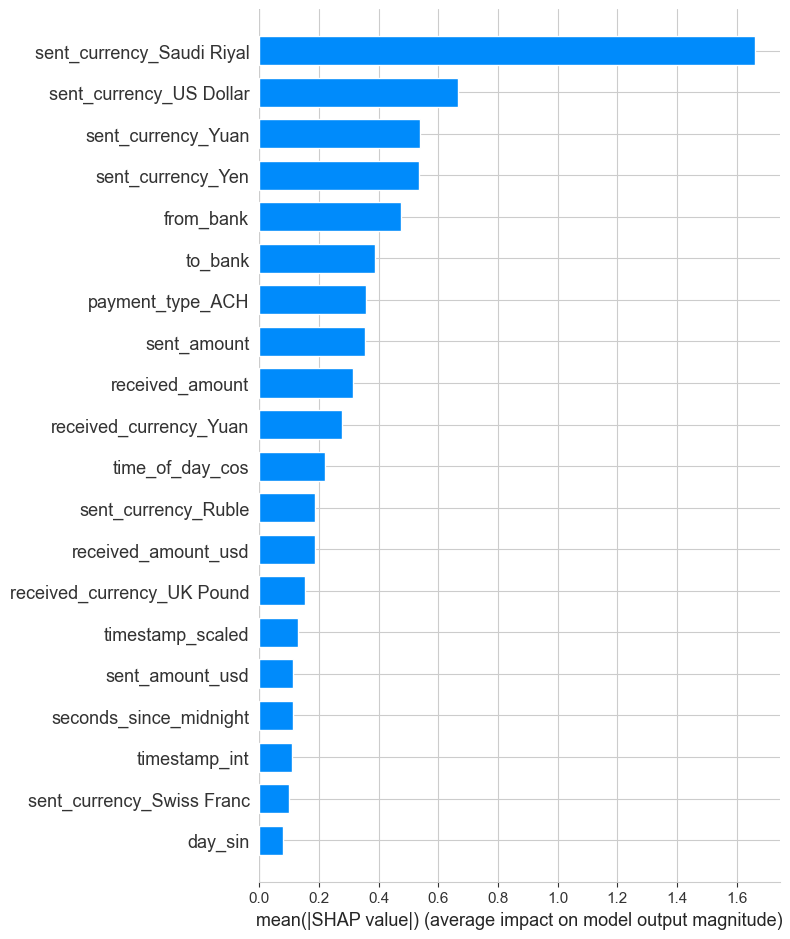

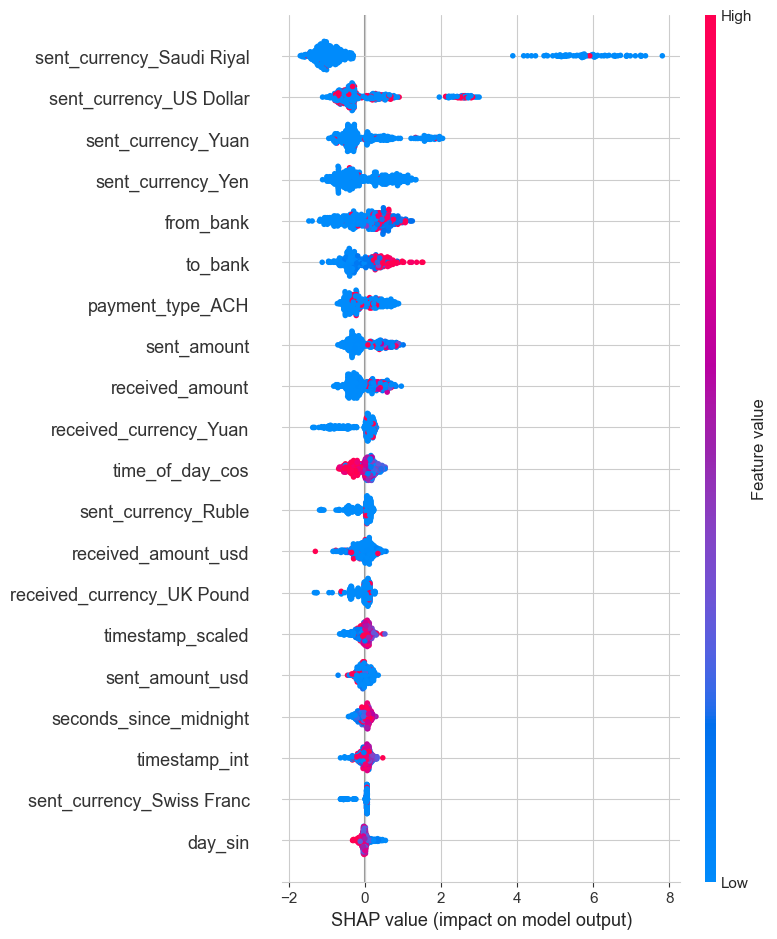

In [64]:
import shap

X_train = X_train.sample(n=500, random_state=42)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap_inter = explainer.shap_interaction_values(X_train)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Summary dot plot (per-sample contribution)
shap.summary_plot(shap_values, X_train)

# Grid Search

In [69]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

# Base model
base_model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    class_weights={0: 1, 1: 12},  # You can tune this too
    silent=True,
    random_seed=42
)

# Define the parameter grid
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'iterations': [300, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'border_count': [32, 64, 128],
    'random_strength': [1, 5, 10]
}

In [70]:
from sklearn.model_selection import StratifiedKFold

# Create a Pool for CatBoost
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(X, y)

# Select only the final features
X_train_sel = X_train[final_selected_features]
X_val_sel = X_val[final_selected_features]
X_test_sel = X_test[final_selected_features]

train_pool = Pool(X_train[final_selected_features], y_train, cat_features=cat_features)

# Use sklearn API
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=30,  # Increase if time allows
    scoring='f1',
    cv=cv,
    verbose=3,
    random_state=42,
    n_jobs=-1
)

# Run search
random_search.fit(X_train[final_selected_features], y_train)

Data split using random_stratified method.

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x3b187eeb0>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'border_count': [32, 64, 128],
                                        'depth': [4, 6, 8, 10],
                                        'iterations': [300, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5, 7, 10],
                                        'learning_rate': [0.01, 0.03, 0.05,
                                                          0.1],
                                        'random_strength': [1, 5, 10]},
                   random_state=42, scoring='f1', verbose=3)

In [71]:
print("Best Parameters:", random_search.best_params_)

# Optional: Save them
best_model = random_search.best_estimator_

# Evaluate on validation and test sets
val_preds = best_model.predict(X_val[final_selected_features])
test_preds = best_model.predict(X_test[final_selected_features])

print("Validation Report:\n", classification_report(y_val, val_preds))
print("Test Report:\n", classification_report(y_test, test_preds))


Best Parameters: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 1000, 'depth': 10, 'border_count': 128}
Validation Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    186859
           1       0.61      0.41      0.49       776

    accuracy                           1.00    187635
   macro avg       0.81      0.71      0.75    187635
weighted avg       1.00      1.00      1.00    187635

Test Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    186859
           1       0.60      0.41      0.49       777

    accuracy                           1.00    187636
   macro avg       0.80      0.70      0.74    187636
weighted avg       1.00      1.00      1.00    187636



## Re-train

In [76]:
X_train, X_val, X_test, y_train, y_val, y_test = xgb_pipeline.split_train_test_val(X,y)

# Select only the final features
X_train_sel = X_train[final_selected_features]
X_val_sel = X_val[final_selected_features]
X_test_sel = X_test[final_selected_features]

final_model = CatBoostClassifier(
    random_strength=1,
    learning_rate=0.1,
    l2_leaf_reg=10,
    iterations=1000,
    depth=10,
    border_count=128,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights={0: 1, 1: 12},
    random_seed=42,
    silent=True
)

model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Data split using random_stratified method.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    186859
           1       0.32      0.52      0.39       777

    accuracy                           0.99    187636
   macro avg       0.66      0.76      0.70    187636
weighted avg       1.00      0.99      0.99    187636

ROC AUC Score: 0.9727


## Results

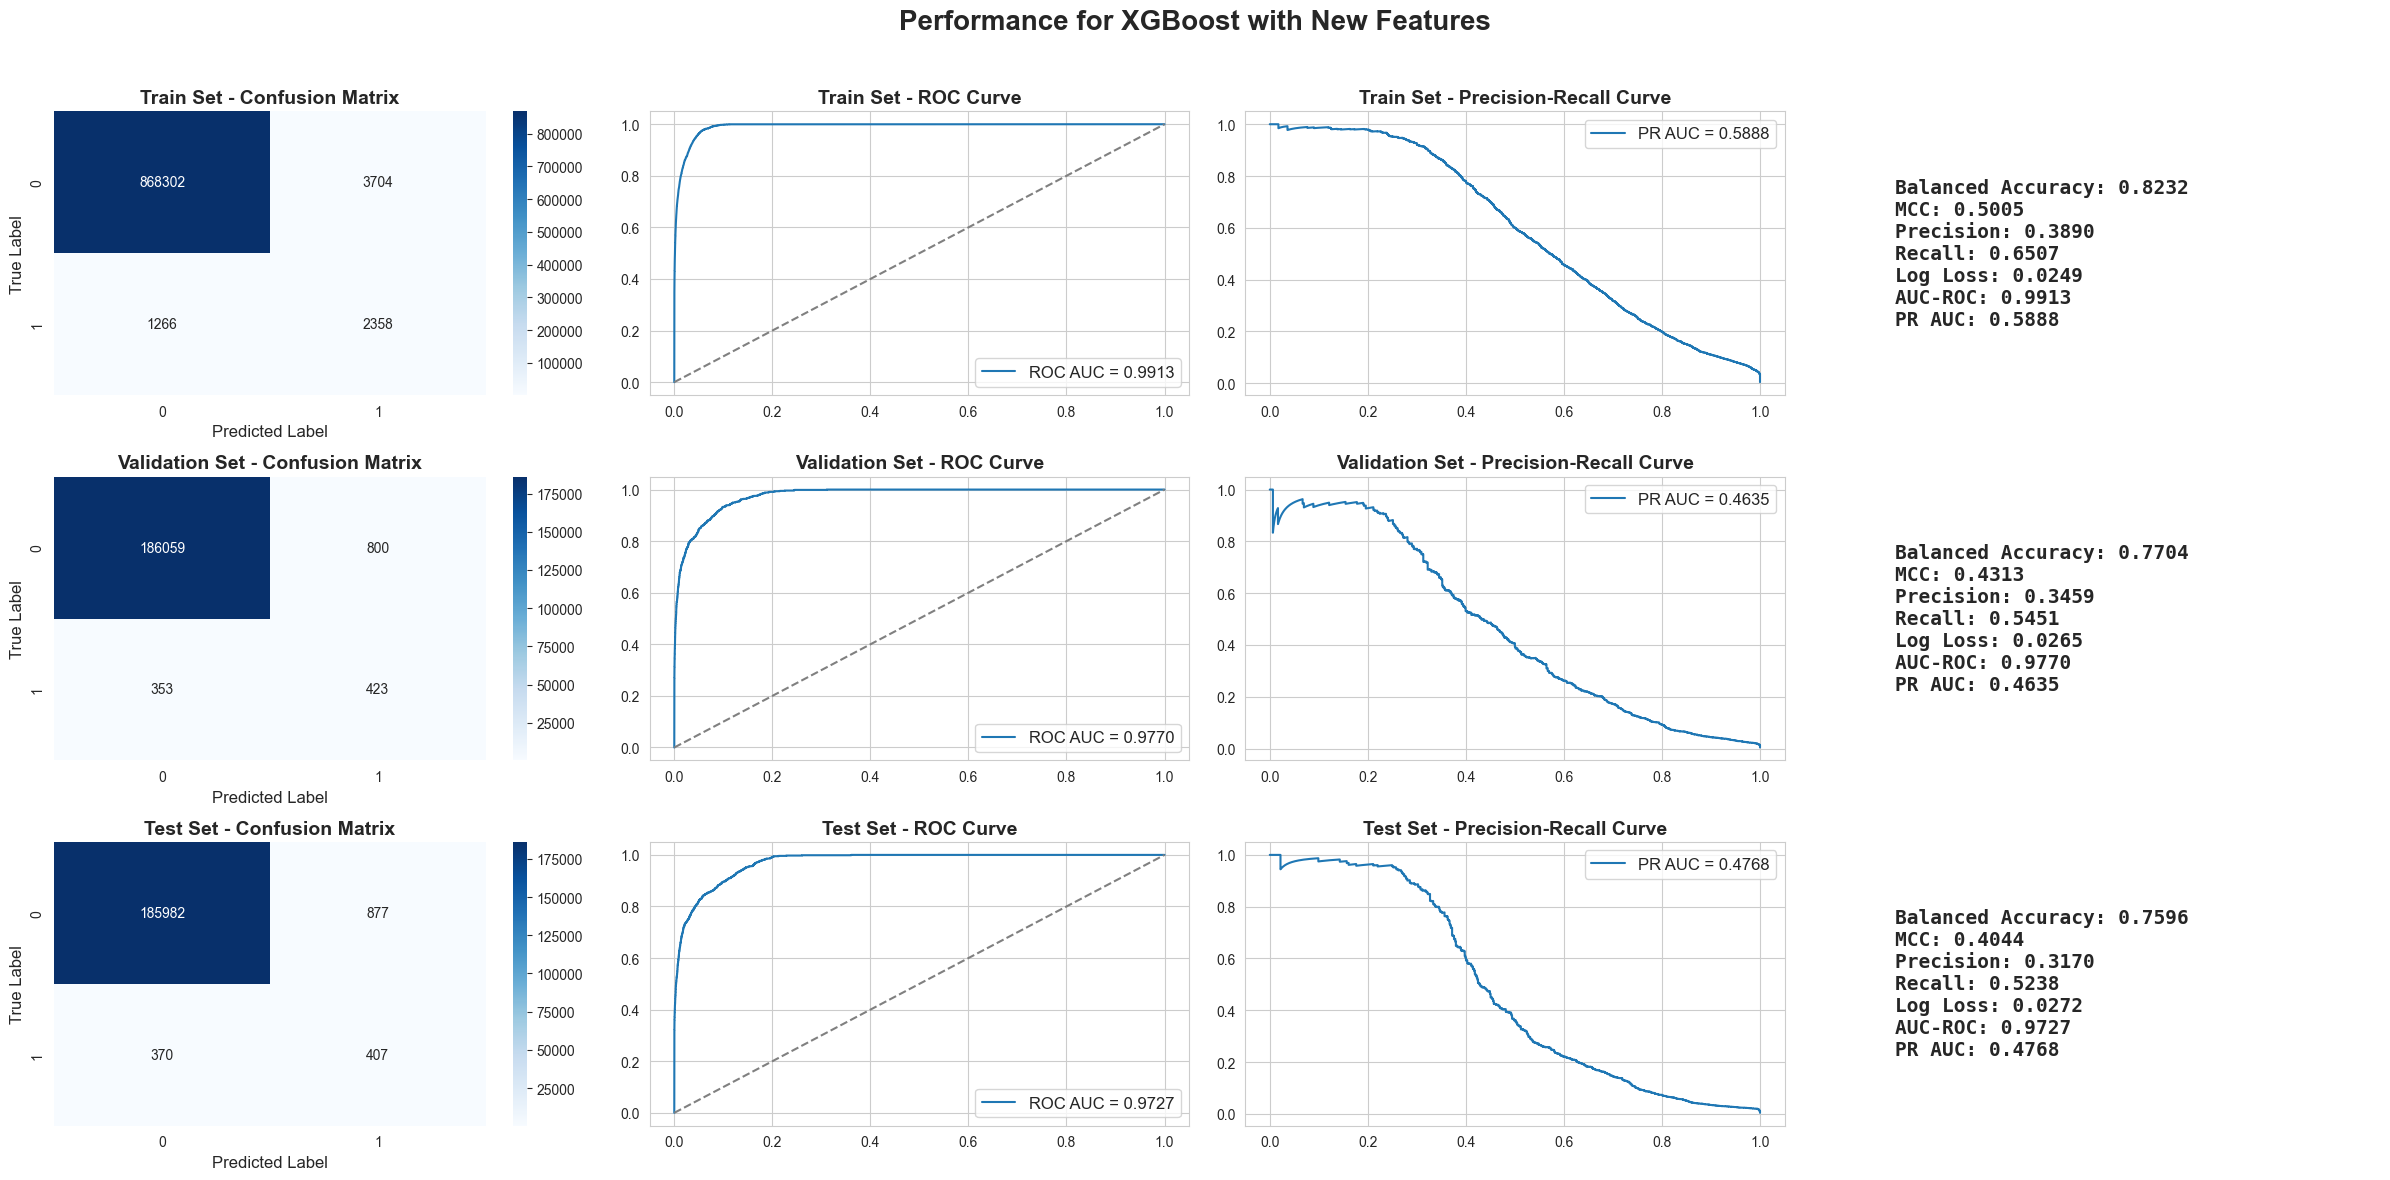

In [78]:
# Train predictions
train_proba = model.predict_proba(X_train)[:, 1]  # Get probability of class 1
train_pred = (train_proba > 0.5).astype(int)

# Validation predictions
val_proba = model.predict_proba(X_val)[:, 1]
val_pred = (val_proba > 0.5).astype(int)

# Test predictions
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba > 0.5).astype(int)


# Evaluate Model Performance
slide_title = "Performance for XGBoost with New Features"
metrics_summary = xgb_pipeline.result_metrics(
    slide_title,
    y_train, train_pred, train_proba,
    y_val, val_pred, val_proba,
    y_test, test_pred, test_proba,
    class_labels=["Licit", "Illicit"]
)